In [1]:
import os
import sys

sys.path.append('../synax/')

import synax
import jax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np

In [2]:
# obtaining integration locations
@jax.jit
def obtain_positions(theta,phi,obs_coord:tuple[float] = (0,10.3,20.6),x_length:float=256,y_length:float=256,z_length:float=128,num_int_points:int=256,epsilon:float=1e-6):
    
    nx = jnp.sin(theta+epsilon)*jnp.cos(phi+epsilon)
    ny = jnp.sin(theta+epsilon)*jnp.sin(phi+epsilon)
    nz = jnp.cos(theta+epsilon)
    
    max_val = jnp.max(jnp.abs(jnp.array([nx/(x_length-obs_coord[0]*jnp.sign(nx)),ny/(y_length-obs_coord[1]*jnp.sign(ny)),nz/(z_length-obs_coord[2]*jnp.sign(nz))])))
    
    int_points = jnp.linspace(0,1,256)
    
    xs = nx/max_val*int_points+obs_coord[0]
    ys = ny/max_val*int_points+obs_coord[1]
    zs = nz/max_val*int_points+obs_coord[2]
    
    return jnp.array([xs,ys,zs])

obtain_vmap = jax.vmap(lambda theta,phi:obtain_positions(theta,phi))

In [3]:
%%time
pos = obtain_positions(1.,jnp.pi)

2024-06-20 11:01:02.607346: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


CPU times: user 256 ms, sys: 766 ms, total: 1.02 s
Wall time: 1.06 s


In [4]:
nside = 256
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)

theta.shape

(786432,)

In [5]:
%%time
poss = obtain_vmap(theta,phi)

CPU times: user 133 ms, sys: 18.6 ms, total: 152 ms
Wall time: 191 ms


Text(0.5, 1.0, '250-th integration points over the y-z plane')

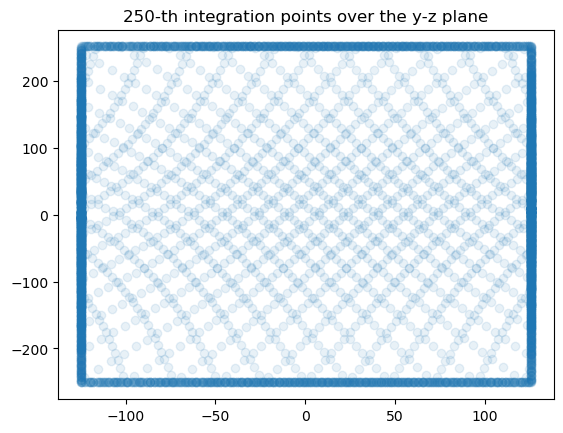

In [18]:
import matplotlib.pyplot as plt
plt.scatter(poss[::100,2,250],poss[::100,1,250],alpha = 0.1)
plt.title("250-th integration points over the y-z plane")

In [8]:
#B_field = jnp.arange(0,512*512*256).reshape((512,512,256))
x_pos = jnp.arange(-256,256)
y_pos = jnp.arange(-256,256)
z_pos = jnp.arange(-128,128)

In [10]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],x_pos,y_pos,z_pos,B_field,method='linear',extrap=True))


In [15]:
# test with a GRF
%%time 
key = jax.random.key(42)
B_field = jax.random.normal(key,(512,512,256),)#jnp.ones((512,512,256))
poss = obtain_vmap(theta,phi)
B_interp = interp_3d(poss)
B_int = B_interp.mean(axis=-1)

B_int.block_until_ready()

CPU times: user 686 ms, sys: 16.2 ms, total: 702 ms
Wall time: 581 ms


Array([ 0.01967774, -0.0028852 , -0.00798964, ..., -0.05285729,
        0.00014852, -0.03246886], dtype=float32)

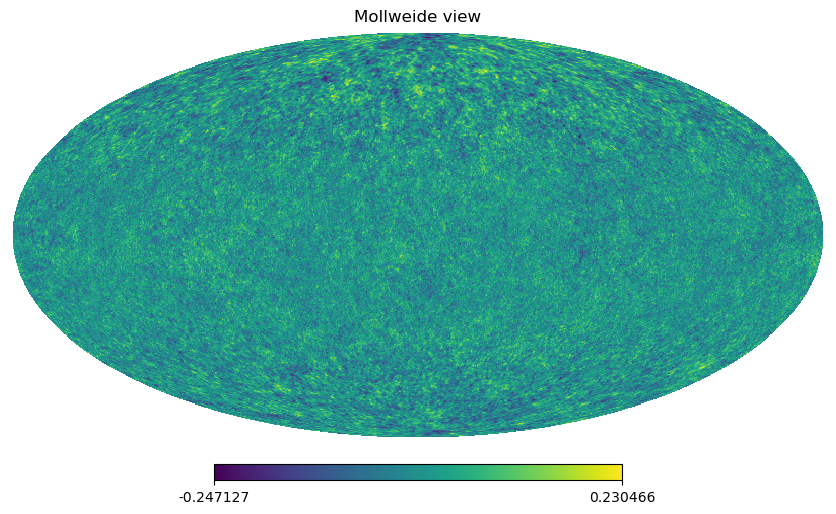

In [16]:
hp.mollview(np.array(B_int))

In [21]:

#B_int = B_interp.mean(axis=-1)